# Reinforcement Learning with AWS DeepRacer
## Problem definition
AWS DeepRacer is a service designed to bring more practitioners to machine learning through a reinforcement learning tournament. Users train agents to complete race tracks in the shortest amount of time, and with the fewest course deviations (i.e. going off track) as possible.

### State representation and observations
At each step, the agent can evaluate the values of 23 variables, which make up the state representation used to design the agent's reward function. Sone of those variables are related to the two actions the agent can perform (steer and change its speed) or to features of the race track in question (list of waypoints, track width, and track length).

For each observation, there are an additional 18 parameter values obtained. Those include booleans expressing, for instance, whether the agent has gone off track or whether all wheels are on the track, and numerical values denoting values such as the agent's progress through the track, its coordinates, and the coordinates of the closest waypoints to the agent.

### Action space
The action space in DeepRacer can be defined to be either continuous or discrete on the original DeepRacer console, but on the Student console it is continuous by default. The agent can take two actions per interval: pick a steering angle, and a "speed." Picking the speed translates to the agent producing an acceleration that would move it toward that speed. Both are defined in the `params` dictionary as floating point numbers, the first in degrees, and the second in meters per second. 

In the fully-fledged DeepRacer console, the user can define the action space to be discrete as long as you use PPO, and have the agent take on speeds and steering angles defined by a granularity parameter. The granularity $g$ of each of the two actions will divide the range of values `steering_angle` and `speed` can take (-30 degrees to 30 degrees, and 0 to 5 m/s, respectively) into $g$ equally-spaced values.

### Deep neural network
The training process in DeepRacer will always be training a policy network $\pi_\theta$. While details on DeepRacer's implementation of SAC under the hood are scarce, we know that it does not admit continuous action spaces. Following OpenAI's description of the SAC algorithm (n.d.), there are two additional Q-networks that learn two Q-functions, used to compute the policy gradient following the update rule:
$$\nabla_\theta \frac{1}{|B|}\sum_{s\in B}\left( \min_{i=1,2} Q_{\phi_i}(s, \tilde a_\theta(s)) - \alpha \log \pi_\theta (\tilde a_\theta(s) | s) \right)$$
Where $\tilde a_\theta(s)$ is an action sampled from the policy network given a state $s$, and $B$ is the batch of transitions sampled from the replay buffer.

In [1]:
# Dictionary below retrieved from documentation at: 
# https://docs.aws.amazon.com/deepracer/latest/student-userguide/student-userguide.pdf

params = {
    "all_wheels_on_track": bool,        # flag to indicate if the agent is on the track
    "x": float,                            # agent's x-coordinate in meters
    "y": float,                            # agent's y-coordinate in meters
    "closest_objects": [int, int],         # zero-based indices of the two closest objects to the agent's current position of (x, y).
    "closest_waypoints": [int, int],       # indices of the two nearest waypoints.
    "distance_from_center": float,         # distance in meters from the track center 
    "is_crashed": bool,                 # Boolean flag to indicate whether the agent has crashed.
    "is_left_of_center": bool,          # Flag to indicate if the agent is on the left side to the track center or not. 
    "is_offtrack": bool,                # Boolean flag to indicate whether the agent has gone off track.
    "is_reversed": bool,                # flag to indicate if the agent is driving clockwise (True) or counter clockwise (False).
    "heading": float,                      # agent's yaw in degrees
    "objects_distance": [float, ],         # list of the objects' distances in meters between 0 and track_length in relation to the starting line.
    "objects_heading": [float, ],          # list of the objects' headings in degrees between -180 and 180.
    "objects_left_of_center": [bool, ], # list of Boolean flags indicating whether elements' objects are left of the center (True) or not (False).
    "objects_location": [(float, float),], # list of object locations [(x,y), ...].
    "objects_speed": [float, ],            # list of the objects' speeds in meters per second.
    "progress": float,                     # percentage of track completed
    "speed": float,                        # agent's speed in meters per second (m/s)
    "steering_angle": float,               # agent's steering angle in degrees
    "steps": int,                          # number steps completed
    "track_length": float,                 # track length in meters.
    "track_width": float,                  # width of the track
    "waypoints": [(float, float), ]        # list of (x,y) as milestones along the track center
}

print(len(params.keys()))

23


### Student DeepRacer
Upon entering the April Student League for DeepRacer, I wrote a simple reward function based on the "follow the center-line" default function offered, and added a class to keep track of previous steering angles. In this case, the reward function rewards steady driving, with turning being frowned upon. This translates to a reward that adds 1 if the steering angle is the same as before, and 0.1 otherwise. The function and results can be seen below. I borrowed ideas from Lueck (2020) in a first exploration of how I could design a reward function.

In [2]:
from PIL import Image

In [3]:
class Reward:
    def __init__(self):
        self.prev_steer_angle = None

    def reward_func(self, params):
        TOTAL_STEPS = 300

        # Read input parameters
        track_width = params['track_width']
        distance_from_center = params['distance_from_center']
        all_wheels_on = params['all_wheels_on_track']
        speed = params['speed']
        steer_angle = params['steering_angle']
        n_steps = params['steps']
        prog = params['progress']

        # Calculate 3 markers that are at varying distances away from the center line
        marker_1 = 0.1 * track_width
        marker_2 = 0.25 * track_width
        marker_3 = 0.5 * track_width

        # Quite unforgiving steering reward
        if self.prev_steer_angle is not None:
            reward = 1 if steer_angle==self.prev_steer_angle else 0.1
        else:
            reward = 1e-3
        
        self.prev_steer_angle = steer_angle

        # Give higher reward if the car is closer to center line and vice versa
        if distance_from_center <= marker_1:
            reward += 1.0
        elif distance_from_center <= marker_2:
            reward += 0.5
        elif distance_from_center <= marker_3:
            reward += 0.1
        else:
            reward = 1e-3

        # Speed reward
        if speed > 3:
            reward += 0.6*speed
        elif speed > 2:
            reward += 0.55*speed
        elif speed > 0:
            reward += 0.4*speed
        else:
            reward -= 0.01

        # Progress reward based on the total number of steps an agent takes in an episode
        if all_wheels_on and n_steps > 0:
            # Reward the agent being "ahead of time"
            if prog > (n_steps/TOTAL_STEPS)*100 and n_steps % 20:
                reward += 3
            # Attempt at adding reward proportional to progress
            else:
                reward += prog*TOTAL_STEPS/(n_steps*100*2)
        else:
            reward = 1e-3

        return float(reward)    


obj = Reward()

def reward_function(params):
    """Defines the reward function used by the agent to steer through the tracks

    Args:
        params (dict): dictionary with each parameter value to be used as environmental feedback
    """
    return obj.reward_func(params)


## DeepRacer April Qualifiers submissions
DeepRacer qualifiers have specific tracks and race types, and I entered my models to compete in the April Qualifiers. The race is a time trial on the Ace Speedway track.
I trained 3 models on the Rogue Circuit track to compete in the qualifiers, though I only submitted the PPO models to evaluation for the leaderboard.

### Hyperparameters
The DeepRacer console allows for the modification of a few hyperparameters to compensate for the apparent inaccessibility of the training algorithms used. In common to SAC and PPO, the user can select a gradient descent batch size of powers of 2 from 32 to 512; the learning rate, between 1e-8 and 1e-3; the discount factor; and the loss function used, either mean squared error or Huber loss.

Besides those four hyperparameters, models using PPO can modify the number of episodes between policy-updating iterations (between 5 and 100), which for SAC is a mandatory 1. SAC, for its part, has an $\alpha$ value between 0 and 1 (default 0.2) which represents the entropy regularization coefficient. The coefficient determines the weight assigned to "novelty" in the objective.
 
### First submission
The first submission to the qualifiers used the reward function below. It rewards gentle steering, in which a steering angle does not differ by more than 2 degrees from the one in the previous step. 

In [4]:
class Reward:
    def __init__(self):
        self.prev_steer_angle = None

    def reward_func(self, params):
        # Default number of steps to use to compare steps taken to total in an episode
        # This varies with the track in question, but I couldn't find a better source
        # that disclosed what the value would be, exactly, with each track used. Regardless,
        # it allows the progress reward to take a more interesting shape
        TOTAL_STEPS = 300

        # Read input parameters
        track_width = params['track_width']
        distance_from_center = params['distance_from_center']
        all_wheels_on = params['all_wheels_on_track']
        speed = params['speed']
        steer_angle = params['steering_angle']
        n_steps = params['steps']
        prog = params['progress']

        # Calculate 3 markers that are at varying distances away from the center line
        marker_1 = 0.1 * track_width
        marker_2 = 0.25 * track_width
        marker_3 = 0.5 * track_width

        # Gentle steering angle reward
        if self.prev_steer_angle is not None:
            reward = 1 if abs(steer_angle-self.prev_steer_angle) < 2 else 0.1
        else:
            reward = 1e-3
        
        # Update steering angle for next time step
        self.prev_steer_angle = steer_angle

        # Give higher reward if the car is closer to center line and vice versa
        if distance_from_center <= marker_1:
            reward += 1.0
        elif distance_from_center <= marker_2:
            reward += 0.5
        elif distance_from_center <= marker_3:
            reward += 0.1
        else:
            reward = 1e-3

        # Speed reward - This works differently in the Student and regular versions of 
        # DeepRacer, because in the student version the maximum speed is 5 meters per second,
        # while in the regular DeepRacer console it is 4 meters per second.
        if speed > 4:
            reward += 0.7*speed
        elif speed > 3:
            reward += 0.6*speed
        elif speed > 2:
            reward += 0.55*speed
        elif speed > 0:
            reward += 0.4*speed
        else:
            # It's not even possible in the regular DR console for the vehicle to stop, since the min speed is customizable but starts at 0.1 m/s, but I only figured that out after using the function
            reward -= 0.01

        # All wheels and progress reward. See comment on TOTAL_STEPS above
        # This block remains the most questionable block of code of the reward function, since it is not clear how the rewards added compare to each other
        if all_wheels_on and n_steps > 0:
            # Every 20 steps, check how the progress is doing relative to expected number of steps taken
            if prog > (n_steps/TOTAL_STEPS)*100 and n_steps%20:
                reward += 3
            else:
                # Attempt at rewarding progress proportionally
                reward += prog*TOTAL_STEPS/(n_steps*100*2)
        elif not all_wheels_on:
            reward = 1e-3

        return float(reward)    


obj = Reward()

def reward_function(params):
    """Defines the reward function used by the agent to steer through the tracks

    Args:
        params (dict): dictionary with each parameter value to be used as environmental feedback
    """
    return obj.reward_func(params)


### Metrics
The evaluation metric used to rank agents is racing time alone. Resets have a time cost, and so veering off track is penalized by setting the agent back on the timer.

When using the DeepRacer console to track the training curve of your model, three quantities are displayed: the average training reward of an iteration, its average percentage training completion, and the average percentage of evaluation completion. The best model is chosen as that which maximizes the last. When performing model evaluation on a second track after training is completed, the user can see how much the agent could complete of a track, in how long, before going off track.

By displaying the curves in the DeepRacer console, one can evaluate whether there is misalignment between track completion and the reward function specified. The function being easily the component which users have the most freedom to tweak, it is helpful to evaluate how correlated reward values are with track completion, and the issues that might arrise when that correlation is low.

### PPO

First, I trained a model using Proximal Policy Optimization, which admits of both discrete and continuous actions spaces. To keep the settings as close as possible to a subsequent SAC model, I chose a continuous action space with limited steering angles between -25 and 25 degrees. The track chosen was Rogue Circuit, because of its forgiving smooth turns which would require constant steering.
The correlation between track completion and reward was relatively high, from the reward graph on the console, especially with training completion. This assuages fears of misalignment between the reward function and the objective used.

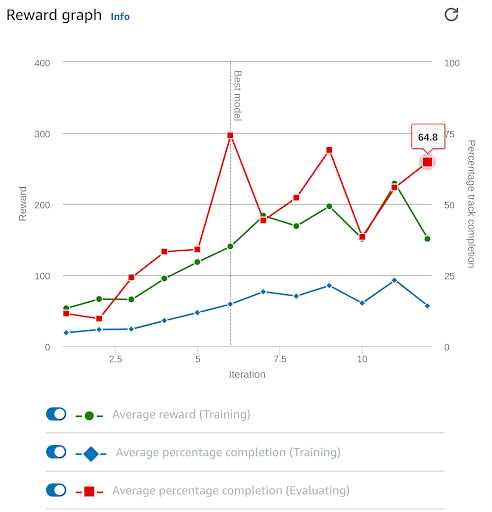

In [5]:
Image.open('img/reward-graph-first-PPO.png')

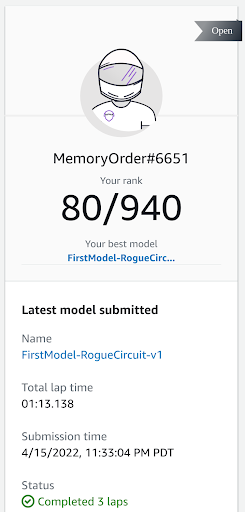

In [6]:
Image.open("img/deepracer-first-model-rank-ppo.png")

### SAC

Some of the training loop can be seen here: https://www.loom.com/share/b8368d9e58a74061b4d30181a585b3c3.

The SAC model was trained with all the same hyperparameters as the PPO model where possible, with the default $\alpha$ coefficient of 0.2. The model's performance was much worse than the PPO one, as can be seen in the training loop. The vehicle made little, but consistent, progress in the training hour it had to improve its policy- and Q-networks.

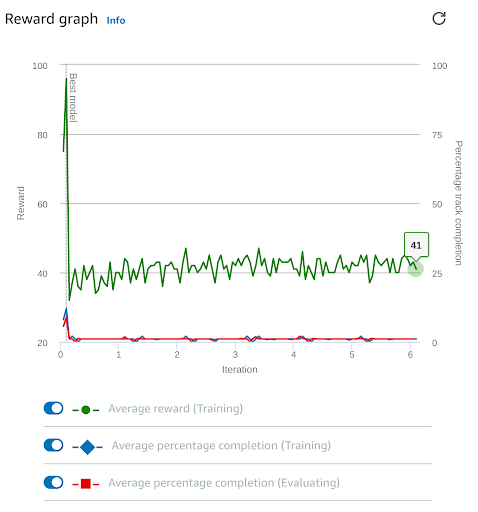

In [7]:
Image.open("img/first-reward-sac.png")

### Second submission
For the second submission, I changed the reward function to include a more reasonable direction reward than simply rewarding consistency. Getting the closest waypoints to the agent, it would compute the angle between them, and reward both heading in that same direction, and steering toward that direction. This approach builds heavily on one of the suggested rewards in Lueck (2020), and it proved decent for the qualifiers track. 

In [8]:
import math

class Reward:
    def __init__(self):
        pass

    def reward_func(self, params):
        TOTAL_STEPS = 300

        # Read input parameters
        track_width = params['track_width']
        distance_from_center = params['distance_from_center']
        all_wheels_on = params['all_wheels_on_track']
        speed = params['speed']
        steer_angle = params['steering_angle']
        n_steps = params['steps']
        prog = params['progress']
        next_point = params['waypoints'][params['closest_waypoints'][1]]
        prev_point = params['waypoints'][params['closest_waypoints'][0]]
        heading = params['heading']

        # Compute angle between the next and the previous waypoints, the two closest, to reward following that direction
        track_dir = math.degrees(math.atan2(next_point[1]-prev_point[1], next_point[0]-prev_point[0]))

        # Calculate 3 markers that are at varying distances away from the center line
        marker_1 = 0.1 * track_width
        marker_2 = 0.25 * track_width
        marker_3 = 0.5 * track_width

        # Track direction reward
        angle_diff = abs(track_dir - heading)
        reward = 1 - (angle_diff/180) if angle_diff < 180 else (1-(360-angle_diff)/180)
        
        # Steering reward guided by the waypoint angle difference
        reward += 1 - (abs(steer_angle - angle_diff)/180)

        # Give higher reward if the car is closer to center line and vice versa
        if distance_from_center <= marker_1:
            reward += 1.0
        elif distance_from_center <= marker_2:
            reward += 0.5
        elif distance_from_center <= marker_3:
            reward += 0.1
        else:
            reward = 1e-3

        # Speed reward
        if speed > 3:
            reward += 0.7*speed
        elif speed > 2:
            reward += 0.6*speed
        elif speed > 0:
            reward += 0.4*speed
        else:
            reward -= 0.01

        # Progress reward
        if all_wheels_on and n_steps > 0:
            if prog > (n_steps/TOTAL_STEPS)*100 and n_steps % 20:
                reward += 3
            else:
                reward += prog*TOTAL_STEPS/(n_steps*100*2)
        elif not all_wheels_on:
            reward = 1e-3

        return float(reward)    


obj = Reward()

def reward_function(params):
    """Defines the reward function used by the agent to steer through the tracks

    Args:
        params (dict): dictionary with each parameter value to be used as environmental feedback
    """
    return obj.reward_func(params)


### Results

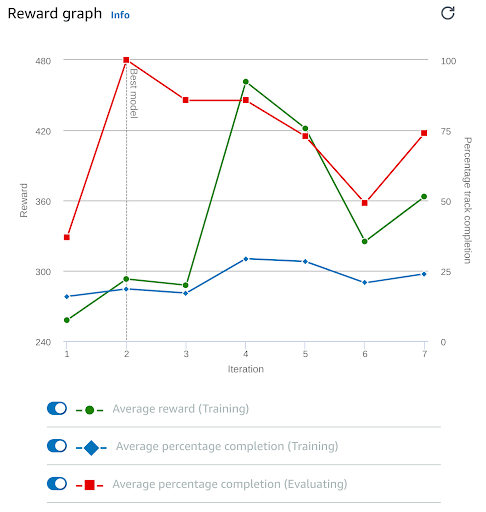

In [9]:
Image.open("img/reward-graph-second-ppo.png")

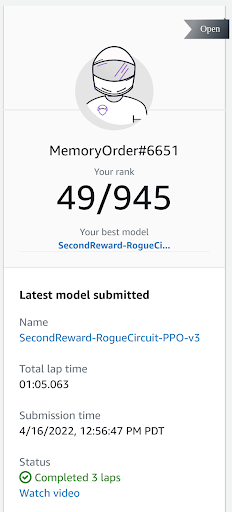

In [10]:
Image.open("img/april-qualifiers-second-model.png")

We can see that the training curve for the second and best model doesn't have an ideal profile. The correlation between evaluation track completion and reward is not very high, considering the best model was achieved with about a quarter as much reward as that with the highest average reward value. This shows an alignment problem between the reward used and the objective used, since evaluation track completion peaked early. This issue could be related to the progress reward value, which may not incentivize behavior as intended. To improve on that block, I would want to use the total number of steps an agent can take in each track.

### Generalizability

There are two clear issues with generalizability of the methods implemented, one with the generalizability of the reward function across different policy gradient methods, and one with the ability of the agent to perform well in new environments.

The first reward function implemented had starkly different performances when the agent was trained using PPO or SAC, thought the hyperparameter values were kept constant, with the exception of the loss function used. While it achieved relatively good performance with PPO, its learning curve with SAC was abysmal, and the agent spent an hour doing sharp left turns that took it off the track. 

When it comes to new environments (new tracks), there is a significant challenge in keeping the agent on track if the course has a different profile of curves relative to the one on which the agent was trained. None of the agents trained could complete over 50% of the tracks used for evaluation after testing, though in the qualifiers the best model could finish the race going off track only once.

### Plans for a budget of \$1000
DeepRacer costs \$ 3.50 per hour of training in the US. \$ 1000 would be roughly equivalent to 285 hours of training, assuming no storage costs (e.g. we do all the training over th course of a month, which would mean about 12 days of training on only one account with no parallelized training, which would probably end up costing quite little in S3 storage just for the month). Taking the race track and car model to be constants, I would try performing a grid search on the tunable hyperparameters and a set of reward functions that assigned different weights to parameters such as speed and steering consistency.

Assuming 3 different reward functions which weigh one of speed, steering conformity, and optimal trajectory similarity, tuning each of the 4 hyperparameters available to all models already provide an extensive grid size. Batch sizes would be kept low, since they're not expected to improve performance (Keskar et al, 2016). Setting about 3 different values for each of the three numerical hyperparameter and trying both losses, there'd be $3^3*2*3=162$ different combinations of hyperparameter values and reward functions. Thus, each model could be trained for between 1.5 hour and 2 hours, which should easily be sufficient to obtain top 5% performance in qualifiers.

## References

Keskar, N. S., Mudigere, D., Nocedal, J., Smelyanskiy, M., & Tang, P. T. P. (2016). On large-batch training for deep learning: Generalization gap and sharp minima. arXiv preprint arXiv:1609.04836.

Lueck, S. (2020). How to win AWS DeepRacer. Retrieved from https://medium.com/axel-springer-tech/how-to-win-aws-deepracer-ce15454f594a

OpenAI. (n.d.). Soft Actor-Critic. Retrieved from https://spinningup.openai.com/en/latest/algorithms/sac.html